In [5]:
import altair as alt
import csv
import matplotlib.pyplot as plt
import numpy as np
import organize_functions
import os
from os import listdir
import pandas as pd
import re
import sort_bus_by_date
from IPython.display import HTML  # For pretty printing!
import datetime as dt
import numpy as np

In [2]:
rootdir = '/mnt/c/Users/flo_y/Desktop/DIRECT_dump/projects/KCM - Local copy/Raw data/False_files/'

In [3]:
def count_mod_changes(directory):
    '''
    
    '''
    keyword = 'Mfg Data (ASCII)'
    list_bus_nums = []  # To get the name of bus number folders
    bus_to_ordered_csvs = {}  # Dictionary associating each bus folder with an chronologically ordered list of CSVs
    bus_to_ordered_dates = {}  # Dictionary associating each bus folder with dates listed chronologically
    file_serials = {}  # Dictionary with serial numbers for each CSV
    list_df = []  # List of dataframes for each bus
    column_names = ['Bus', 'Module', 'Date', 'Change']
    num_mods = 16  # Constant number of mods
    module_index = 8  # For grabbing module string indices later
    bus_single = 5
    bus_double = 6
    last_two_chars = -2  # For grabbing last two characters
    last_one_chars = -1  # For grabbing last character
    mod_index = ['Module ' + str(i) for i in range(1, num_mods + 1)]  # Creating rows for dataframe
    mod_change_count = {}  # Dictionary for number of changes, sum value for each module # as compared file to file

    
    keyword = 'Mfg Data (ASCII)'  # Keyword to search for
    for file in listdir(directory):  # Place this file in directory with False_files -> Keiton's code
        if file.startswith('bus'):
            list_bus_nums.append(file)  # Getting list of bus names
    for bus in list_bus_nums:  # For each bus
        ordered_dates = []
        df = sort_bus_by_date.sort_bus_by_date(directory, bus + '/')
        ordered_csv = df['Filename'].tolist()
        ordered_unclean_dates = df['DateRetrieved'].tolist()
        for unclean_date in ordered_unclean_dates:
            split_results = unclean_date.strftime('%m/%d/%Y %H:%M:%S')
            ordered_dates.append(split_results)
        bus_to_ordered_csvs[bus] = ordered_csv  # Grabbing a sorted list of CSV's for each bus folder
        bus_to_ordered_dates[bus] = ordered_dates  # Grabbing a sorted list of dates for each folder
    for bus_key in bus_to_ordered_csvs:  # For each bus folder (key value for bus to ordered files dictionary)
        
        for mod_name in mod_index:  # Setting dictionary with all module count at 0 to start. Should be for each bus. 
            mod_change_count[mod_name] = [0]  # Add the dataframe at the end of the comparisons to the list_df
        
        ordered_dates = bus_to_ordered_dates[bus_key]  # Grab list of dates for dataframe use later
        ordered_csvs = bus_to_ordered_csvs[bus_key]  # Grab the list of ordered CSV's associated with current bus folder
        for i in range(len(ordered_csvs)):  # For each file in the list of ordered CSV's
            serial_nums = []  # Start with empty list of serial numbers for that file
            with open(directory +  bus_key + '/' + ordered_csvs[i]) as file:  # Looking through current file
                reader = csv.reader(file)
                for row in reader:
                    for element in row:
                        if keyword in element:
                            mod_num = re.sub(r'\W+', '', element[17:]).lower()
                            serial_nums.append(mod_num)  # Grabbing serial numbers for each CSV file
                        else:
                            pass
            # After you get all the serial numbers for a file
            serial_nums.pop(0)  # Getting rid of first module number
            file_serials[ordered_csvs[i]] = serial_nums  # Key: file name. Value: List of serial numbers for that file name
        
        # At this point, we have a list of serial numbers associated with each CSV file
        i = 0
        while(i < len(ordered_csvs) - 1):  # While we are not looking at the last file (can't compare last file with anything)
            first_mods = file_serials[ordered_csvs[i]]  # Gets you first list of serials
            next_mods = file_serials[ordered_csvs[i + 1]] # Get second list of serials
            for j in range(len(first_mods)):  # For each index (mod #) in the list of modules
                mod_string = "Module " + str(j + 1)  # For first iteration, "Module 1"
                if first_mods[j] != next_mods[j]:
                    mod_change_count[mod_string].append(mod_change_count[mod_string][-1] + 1)  # If different, append prev. count + 1
                else:
                    mod_change_count[mod_string].append(mod_change_count[mod_string][-1])  # If same, just append prev. count
            i += 1
        
        # Now we have dictionary with count of changes per file compared for each module (16 mods) 
        num_comps = len(ordered_csvs) - 1
        bus_num_element = ''
        if len(bus_key) == bus_single:
            bus_num_element = bus_key[-1]
        elif len(bus_key) == bus_double:
            bus_num_element = bus_key[-2:]
        else:
            bus_num_element = bus_key[-3:]
#         print(bus_num_element)
        bus_number_list = [bus_num_element for i in range((num_comps + 1) * num_mods)] # To get the bus # values
        module_labels = []
        change_labels = []
        mod_num_label = ''
        for mod_label in mod_change_count.keys():  # For each module number 1 through 16
            change_labels += mod_change_count[mod_label]
#             if len(mod_label) > module_index:
#                 mod_num_label = mod_label[last_two_chars:]
#             else:
#                 mod_num_label = mod_label[last_one_chars]
            for i in range(num_comps + 1):
                module_labels.append(mod_label)
        date_labels = ordered_dates * num_mods
#         print("Bus numbers: ", len(bus_number_list), "\n Module numbers: ", module_labels, "\n Change labels: ", len(change_labels), "\n Date labels: ", len(date_labels))
        data_lists = [bus_number_list, module_labels, date_labels, change_labels]
        df_dict = {}
        for column, data_list in zip(column_names, data_lists):
            df_dict[column] = data_list
        df_bus_changes = pd.DataFrame(data=df_dict)
        list_df.append(df_bus_changes)
    return pd.concat(list_df, axis=0)


# #I am not sure why i need to do so many roundabout steps with the dataframe but this is the way i could get it to work haha

In [33]:
df1 = count_mod_changes(rootdir)

In [17]:
df1

,Bus,Module,Date,Change
0,1,Module 1,09/26/2016 06:07:22,0
1,1,Module 1,11/14/2016 09:56:09,0
2,1,Module 1,02/03/2017 06:25:25,0
3,1,Module 1,04/11/2017 09:29:47,0
4,1,Module 1,09/19/2017 11:39:26,0
...,...,...,...,...
75,99,Module 16,12/23/2016 12:16:35,0
76,99,Module 16,09/18/2017 06:43:27,0
77,99,Module 16,09/18/2017 10:52:47,1
78,99,Module 16,02/26/2018 06:40:43,1


In [34]:
df1.to_csv('heat map.csv')

In [35]:
df2 = pd.read_csv('heat map.csv')

In [20]:
df2

,Unnamed: 0,Bus,Module,Date,Change
0,0,1,Module 1,09/26/2016 06:07:22,0
1,1,1,Module 1,11/14/2016 09:56:09,0
2,2,1,Module 1,02/03/2017 06:25:25,0
3,3,1,Module 1,04/11/2017 09:29:47,0
4,4,1,Module 1,09/19/2017 11:39:26,0
...,...,...,...,...,...
10507,75,99,Module 16,12/23/2016 12:16:35,0
10508,76,99,Module 16,09/18/2017 06:43:27,0
10509,77,99,Module 16,09/18/2017 10:52:47,1
10510,78,99,Module 16,02/26/2018 06:40:43,1


In [36]:
df3 = df2.drop(columns=['Unnamed: 0'])

In [22]:
df3

,Bus,Module,Date,Change
0,1,Module 1,09/26/2016 06:07:22,0
1,1,Module 1,11/14/2016 09:56:09,0
2,1,Module 1,02/03/2017 06:25:25,0
3,1,Module 1,04/11/2017 09:29:47,0
4,1,Module 1,09/19/2017 11:39:26,0
...,...,...,...,...
10507,99,Module 16,12/23/2016 12:16:35,0
10508,99,Module 16,09/18/2017 06:43:27,0
10509,99,Module 16,09/18/2017 10:52:47,1
10510,99,Module 16,02/26/2018 06:40:43,1


In [37]:
data = df3.melt(id_vars=['Bus', 'Module', 'Date'])

In [24]:
data

,Bus,Module,Date,variable,value
0,1,Module 1,09/26/2016 06:07:22,Change,0
1,1,Module 1,11/14/2016 09:56:09,Change,0
2,1,Module 1,02/03/2017 06:25:25,Change,0
3,1,Module 1,04/11/2017 09:29:47,Change,0
4,1,Module 1,09/19/2017 11:39:26,Change,0
...,...,...,...,...,...
10507,99,Module 16,12/23/2016 12:16:35,Change,0
10508,99,Module 16,09/18/2017 06:43:27,Change,0
10509,99,Module 16,09/18/2017 10:52:47,Change,1
10510,99,Module 16,02/26/2018 06:40:43,Change,1


In [38]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [40]:
select_bus = alt.selection_single(
    name='Select', fields=['Bus'], init={'Bus': 1},
    bind=alt.binding_range(min=1, max=130, step=1)
)

chart = alt.Chart(data).mark_rect(stroke='black').encode(
    x=alt.X('Date', title="Date", sort=None),
    y=alt.Y('Module', title="Module", sort=None),
    color=alt.Color('value', legend=None)
).add_selection(select_bus).transform_filter(select_bus)

chart

alt.Chart(...)

In [248]:
chart.save('chart.html')

# Some stats

In [355]:
grouped = df3.groupby(['Bus', 'Module'], sort=None)['Change'].max()
grouped

Bus  Module   
1    Module 1     0
     Module 2     2
     Module 3     1
     Module 4     1
     Module 5     1
                 ..
99   Module 12    1
     Module 13    1
     Module 14    0
     Module 15    1
     Module 16    1
Name: Change, Length: 2000, dtype: int64

In [356]:
average = grouped.groupby(['Module'], sort=None).mean()
average

Module
Module 1     0.664
Module 2     0.704
Module 3     0.728
Module 4     0.784
Module 5     0.720
Module 6     0.760
Module 7     0.712
Module 8     0.728
Module 9     0.656
Module 10    0.744
Module 11    0.776
Module 12    0.768
Module 13    0.720
Module 14    0.760
Module 15    0.720
Module 16    0.680
Name: Change, dtype: float64

<AxesSubplot:xlabel='Module'>

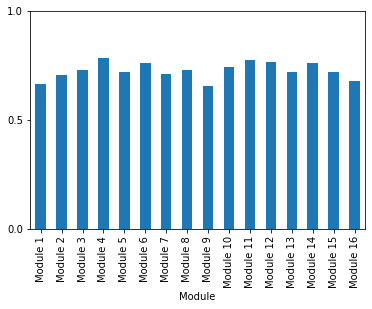

In [357]:
average.plot(kind='bar', title='', yticks=[0,0.5,1.0])

<AxesSubplot:xlabel='Module'>

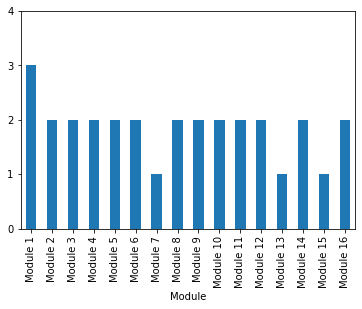

In [358]:
grouped2 = df3.groupby(['Module'], sort=None)['Change'].max()
grouped2.plot(kind='bar', title='', yticks=[0,1,2,3,4])

In [3]:
df_dates = pd.read_csv('dates.csv')
df_dates

,Bus,Module,Start date,End date
0,1,2,9/26/2016,02/03/2017
1,2,11,7/31/2018,12/26/2018
2,6,5,3/17/2016,12/21/2016
3,15,2,2/28/2017,7/31/2017
4,25,1,04/04/2017,10/16/2017
5,25,3,03/10/2016,04/04/2017
6,25,4,03/10/2016,04/04/2017
7,25,6,03/10/2016,04/04/2017
8,28,16,6/21/2017,09/08/2017
9,32,3,9/25/2016,12/05/2016


In [11]:
df_dates['Start date']= pd.to_datetime(df_dates['Start date'])
df_dates['End date']= pd.to_datetime(df_dates['End date'])
df_dates

,Bus,Module,Start date,End date
0,1,2,2016-09-26,2017-02-03
1,2,11,2018-07-31,2018-12-26
2,6,5,2016-03-17,2016-12-21
3,15,2,2017-02-28,2017-07-31
4,25,1,2017-04-04,2017-10-16
5,25,3,2016-03-10,2017-04-04
6,25,4,2016-03-10,2017-04-04
7,25,6,2016-03-10,2017-04-04
8,28,16,2017-06-21,2017-09-08
9,32,3,2016-09-25,2016-12-05


In [22]:
df_dates['Lifespan'] = (df_dates['End date'] - df_dates['Start date']).dt.days
df_dates

,Bus,Module,Start date,End date,Lifespan
0,1,2,2016-09-26,2017-02-03,130
1,2,11,2018-07-31,2018-12-26,148
2,6,5,2016-03-17,2016-12-21,279
3,15,2,2017-02-28,2017-07-31,153
4,25,1,2017-04-04,2017-10-16,195
5,25,3,2016-03-10,2017-04-04,390
6,25,4,2016-03-10,2017-04-04,390
7,25,6,2016-03-10,2017-04-04,390
8,28,16,2017-06-21,2017-09-08,79
9,32,3,2016-09-25,2016-12-05,71


In [23]:
df_dates["Lifespan"].mean()

208.0

<AxesSubplot:ylabel='Frequency'>

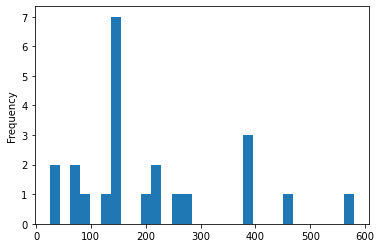

In [32]:
df_dates["Lifespan"].plot.hist(bins=30)

In [25]:
grouped = df_dates.groupby(['Module'])['Lifespan'].mean()
grouped

Module
1     227.000000
2     139.666667
3     200.666667
4     207.500000
5     210.000000
6     390.000000
8     580.000000
9     111.000000
10    179.000000
11    148.000000
12    242.500000
14    212.000000
16     79.000000
Name: Lifespan, dtype: float64

<AxesSubplot:xlabel='Module'>

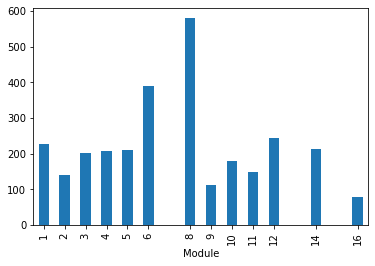

In [30]:
grouped.plot.bar()